In [1]:
# Images downscaled to 64 X 64

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
from scipy.signal import convolve2d
import tensorflow as tf

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
tf.version.VERSION

'1.15.0'

In [3]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [4]:
dat['listgal'].shape

(300, 96, 96)

In [5]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [6]:
gal = cv.resize(dat['listgal'][0,:,:], (64,64))
psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))

psf /= np.sum(psf)

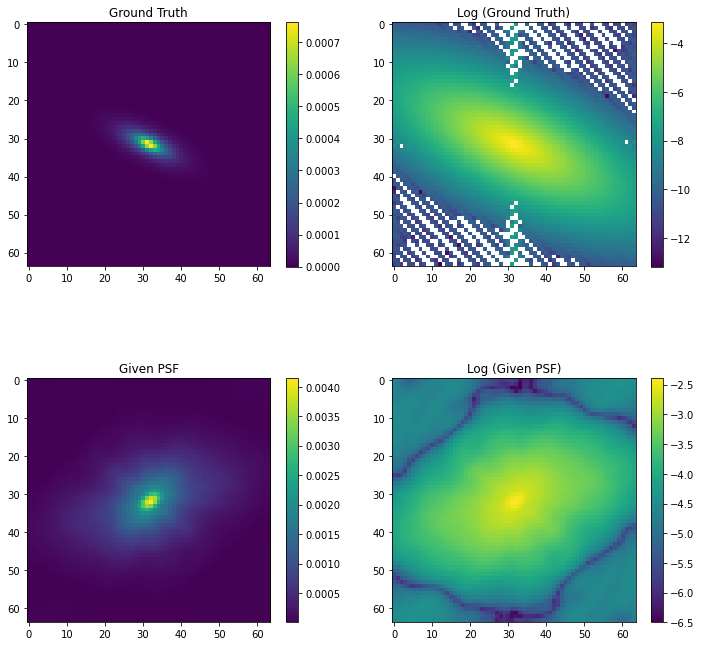

In [7]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal)
plt.colorbar(shrink=0.825)
plt.title('Ground Truth')

plt.subplot(222)
plt.imshow(np.log10(gal))
plt.colorbar(shrink=0.825)
plt.title('Log (Ground Truth)')

plt.subplot(223)
plt.imshow(psf)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

plt.show()

### FFT(Ground Truth) + Gaussian Noise

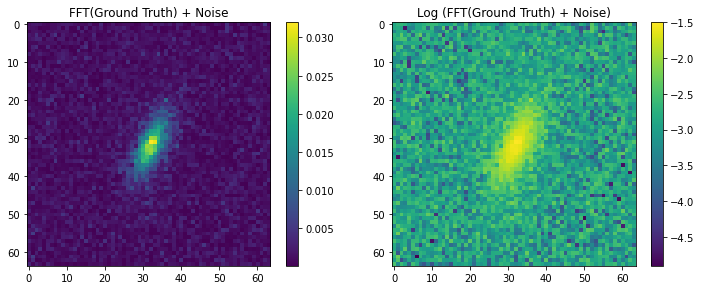

In [8]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                                       # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

### Convolve with PSF

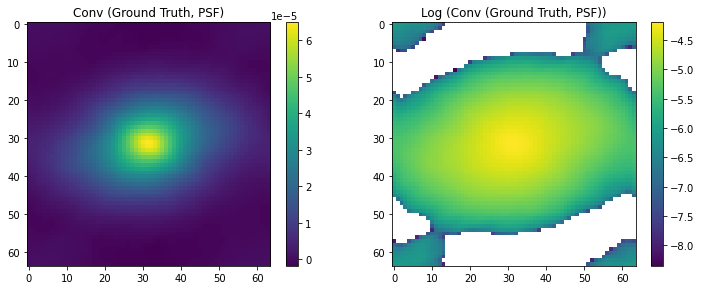

In [9]:
pad = 20        # Padding to remove aliasing

conv_padded = np.pad(gal_fft_GSO.array, pad) * np.pad(psf_fft, pad)
conv = conv_padded[pad:conv_padded.shape[0]-pad, pad:conv_padded.shape[1]-pad]

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))  # IFFT to get back to brightness domain
final_gal = final_gal * (np.sum(gal)/np.sum(final_gal))                     # Normalisation


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

# ADMM in TensorFlow

In [10]:
def ADMM_tf(gal, final_gal, psf, n_iter, disp_step):
    
    
    # Convert arrays to tensors
    
    gal_tf = tf.cast(gal, dtype='complex128')
    final_gal_tf = tf.cast(final_gal, dtype='complex128')
    psf_tf = tf.cast(psf, dtype='complex128')
    
    
    
    # Utility Functions

    def fftconvolve(image, kernel):

        x = tf.signal.fftshift(tf.signal.fft2d(image))
        y = tf.signal.fftshift(tf.signal.fft2d(kernel))
        result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

        return tf.cast(result, dtype='complex128')


    def fft(data):

        return ( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], dtype='complex128') * 
                 tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) )


    def ifft(data):

        return ( tf.convert_to_tensor(data.get_shape().as_list()[0], dtype='complex128') *
                 tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) )


    def soft_thresh(data, threshold):

        return tf.cast(tf.math.maximum((1.0 - threshold/tf.math.abs(data)), 0.0), dtype='complex128') * data


    def nmse(signal_1, signal_2):

        return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)
    
    
    
    
    # Projection - Enforce non-negative values
    def proj(xi):

        return tf.cast(tf.math.maximum(tf.math.real(xi), 0.0), dtype='complex128')


    # H operator
    def H(data, psf):

        return fftconvolve(data, psf)


    # H transpose operator
    def Ht(data, psf):

        return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


    # The gradient
    def grad(y, x_rec, psf):

        return ifft(Ht(H(fft(x_rec), psf) - y, psf))


    # The cost function
    def cost_func(y, x_rec, z, mu, rho, psf, var=1.0):

        cost_val = ( tf.cast(0.5, dtype='complex128') * rho * tf.norm((z - x_rec))**2  -
                     tf.tensordot(mu, (z - x_rec), 1)  +
                     tf.cast(0.5/var, dtype='complex128') * tf.norm(y - H(fft(x_rec), psf))**2 )

        return cost_val
    
    
    

    def runADMM(observation, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, 
                delta_0, disp_step, ST_lambda, n_iter, alpha=1.0):

        cost = []
        nmse_arr = np.zeros(n_iter)
        x_opt = tf.zeros(tf.shape(observation.shape), dtype='complex128')
        count = 0

        # ADMM parameters
        x_k = first_guess
        z_k = z_0
        z_k1 = z_k
        mu_k = mu_0
        rho_k = rho_0         # Augmented lagrangian hyperparameter
        rho_k1 = rho_k
        delta_k = delta_0      

        # FISTA parameters
        t_k = tf.cast(1.0, dtype='complex128')
        z_fista_old = first_guess
        sigma = tf.cast(0.0, dtype='complex128')


        for k in range(n_iter):

            # FISTA update

            x_rec = z_fista_old - alpha * (grad(observation, z_fista_old, psf) + 
                                           mu_k * sigma**2 + 
                                           rho_k * sigma**2 * (z_fista_old - z_k))  

            x_rec = soft_thresh(x_rec, ST_lambda)
            x_rec = proj(x_rec)

            t_k1 = ( (tf.cast(1.0, dtype='complex128') + 
                      tf.math.sqrt(tf.cast(4.0, dtype='complex128')*t_k**2 + tf.cast(1.0, dtype='complex128'))) 
                    / tf.cast(2.0, dtype='complex128') )

            lambda_fista = tf.cast(1.0, dtype='complex128') + (t_k - tf.cast(1.0, dtype='complex128')) / t_k1

            z_fista_new = x_k + lambda_fista * (x_rec - x_k)

            z_fista_old = z_fista_new
            t_k = t_k1



            # Denoising
            z_k1 = x_rec + mu_k/rho_k

            gauss_kernel = tf.cast(np.expand_dims(gen_kernel(), axis=(-1, -2)), dtype='float64')
            z_k1_4d = tf.expand_dims(tf.expand_dims(tf.math.abs(z_k1), axis=0), axis=-1)

            conv_4d = tf.nn.conv2d(z_k1_4d, gauss_kernel, strides=[1, 1, 1, 1], padding='SAME')
            z_k1 = tf.cast(tf.squeeze(conv_4d), dtype='complex128')

            
            
            # mu update
            mu_k1 = mu_k + (x_rec - z_k1)*rho_k


            # Cost
            cost.append(cost_func(observation, x_rec, z_k1, mu_k1, rho_k, psf))


            # Rho update
            delta_k1 = ( tf.cast(1.0/final_gal_tf.get_shape().as_list()[0], dtype='complex128') * 
                         (tf.norm(x_rec - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k)) )


            if ( tf.keras.backend.get_value(tf.math.abs(delta_k1)) >= tf.keras.backend.get_value(tf.math.abs(eta * delta_k)) and  
                 tf.keras.backend.get_value(tf.math.abs(rho_k1)) < tf.keras.backend.get_value(tf.math.abs(rho_max)) ):

                rho_k1 = gamma * rho_k

            else:
                rho_k1 = rho_k  


            x_k = x_rec
            mu_k = mu_k1
            z_k = z_k1
            rho_k = rho_k1


            # Convert back to signal domain
            final_im = tf.math.abs(fft(x_rec))
            nmse_arr[k] = nmse(gal_tf, tf.cast(final_im, dtype='complex128'))


            if (k!=0) and (nmse_arr[k]<nmse_arr[k-1]) and count==0:
                x_opt = final_im
            elif (k!=0) and (nmse_arr[k]>nmse_arr[k-1]):
                count += 1


            if k%disp_step==0 and k!=0:

                fig = plt.subplots(1,3, figsize=(25,25))

                plt.subplot(131)
                plt.title('Reconstruction after {} iterations'.format(k))
                ax1 = plt.gca()
                im1 = ax1.imshow(tf.keras.backend.get_value(final_im))
                divider = make_axes_locatable(ax1)
                cax1 = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im1, cax=cax1)

                plt.subplot(132)
                plt.title('Log Scale Intensity')
                plt.imshow(np.log10(tf.keras.backend.get_value(final_im)))

                plt.subplot(133)
                plt.title('Intensity Plot (Central Slice)')
                ax3 = plt.gca()
                ax3.plot(tf.keras.backend.get_value(final_im)[observation.get_shape().as_list()[0]//2,:], label='rec_im')           
                ax3.plot(tf.keras.backend.get_value(gal_tf)[observation.get_shape().as_list()[0]//2,:], label='gal')  
                plt.legend()
                ax3.set_aspect(1.0/ax3.get_data_ratio())

                plt.show(fig)

        return final_im, x_opt, nmse_arr, cost



    # ADMM parameters (initial)
    z_0 = tf.zeros(tf.shape(final_gal_tf), dtype='complex128')
    mu_0 = tf.cast(0.0, dtype='complex128')
    rho_0 = tf.cast(50.0, dtype='complex128')         # Augmented lagrangian hyperparameter
    rho_max = tf.cast(200.0, dtype='complex128')      # max rho value
    eta = tf.cast(0.5, dtype='complex128')            # should be between - [0, 1)
    gamma = tf.cast(1.4, dtype='complex128')          # multiplicative rho factor -- Should be > 1
    delta_0 = tf.cast(0.0, dtype='complex128')

    first_guess = tf.zeros(tf.shape(final_gal_tf), dtype='complex128')


    # Deconvolve the image
    final_im, x_opt, nmse_arr, cost = runADMM(final_gal_tf, first_guess, psf_tf, grad, z_0, mu_0, rho_0, rho_max, 
                                              eta, gamma, delta_0, disp_step, ST_lambda=1e-15, n_iter=n_iter)
    
    
    
    # Comparison

    temp = tf.concat([x_opt, tf.math.real(gal_tf)], 1)

    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

    ax1 = plt.subplot(gs[0])
    plt.title('Observation')
    ax1 = plt.gca()
    im1 = ax1.imshow(tf.keras.backend.get_value(tf.math.abs(final_gal_tf)))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    ax2 = plt.subplot(gs[1])
    plt.title('Optimal Reconstruction vs. Ground Truth')
    ax2 = plt.gca()
    im2 = ax2.imshow(tf.keras.backend.get_value(temp))
    ax2.axis('off')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="2.5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.tight_layout()


    fig2 = plt.subplots(1,3, figsize=(22,22))
    plt.subplot(131)
    plt.title('Residual (Y - H*X_est)')
    ax1 = plt.gca()
    im1 = ax1.imshow(tf.keras.backend.get_value(tf.math.abs(final_gal_tf - fftconvolve(psf_tf, tf.cast(x_opt, dtype='complex128')))))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    plt.subplot(132)
    plt.title('Log [FFT (Residual (Y - H*X_est))]')
    ax2 = plt.gca()
    im2 = ax2.imshow(tf.keras.backend.get_value(tf.math.log(tf.math.abs(fft(final_gal_tf - fftconvolve(psf_tf, tf.cast(x_opt, dtype='complex128')))))))
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.subplot(133)
    plt.title('Error (X_true - X_est)')
    ax3 = plt.gca()
    im3 = ax3.imshow(tf.keras.backend.get_value(x_opt - tf.math.real(gal_tf)))
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)

    plt.show(fig2)
     
    plot_nmse(nmse_arr, n_iter)    
    
    return x_opt, nmse_arr

# ADMM in NumPy

In [11]:
def ADMM_np(gal, final_gal, psf, n_iter, disp_step):
    
    
    # Utility Functions

    def fftconvolve(image, kernel):

        x = np.fft.fftshift(np.fft.fftn(image))
        y = np.fft.fftshift(np.fft.fftn(kernel))

        return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))


    def fft(data):

        return (1 / np.sqrt(data.size) *
                np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


    def ifft(data):

        return (np.sqrt(data.size) *
                np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))


    def soft_thresh(data, threshold):

        return np.around(np.maximum((1.0 - threshold /
                         np.maximum(np.finfo(np.float64).eps, np.abs(data))), 0.0) * data,
                         decimals=15)


    def nmse(signal_1, singal_2):

        return (np.linalg.norm(singal_2 - signal_1) ** 2 /
                np.linalg.norm(signal_1) ** 2)
    
    
    # Projection - Enforce non-negative values
    def proj(xi):

        xi = np.maximum(xi,0)
        return xi


    # H operator
    def H(data, psf):

        return fftconvolve(data, psf)


    # H transpose operator
    def Ht(data, psf):

        return fftconvolve(data, np.rot90(psf, 2))


    # The gradient
    def grad(y, x_rec, psf):

        return ifft(Ht(H(fft(x_rec), psf) - y, psf))


    # The cost function
    def cost_func(y, x_rec, z, mu, rho, psf, var=sigma_noise):

        cost_val = (0.5*rho*np.linalg.norm(z-x_rec)**2 - 
                    np.dot(mu.flatten(),(z-x_rec).flatten()) + 
                    (0.5/var)*np.linalg.norm(y - H(fft(x_rec), psf))**2)

        return cost_val




    def runADMM(observation, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, 
                delta_0, disp_step, ST_lambda, n_iter, alpha=1.0):

        cost = []
        nmse_arr = np.zeros(n_iter)
        x_opt = np.zeros(observation.shape)
        count = 0

        # ADMM parameters
        x_k = first_guess
        z_k = z_0
        z_k1 = z_k
        mu_k = mu_0
        rho_k = rho_0         
        rho_k1 = rho_k
        delta_k = delta_0      

        # FISTA parameters
        t_k = 1
        z_fista_old = first_guess
        sigma = 0.0


        for k in range(n_iter):

            # FISTA update

            x_rec = z_fista_old - alpha * (grad(observation, z_fista_old, psf) + 
                                           mu_k * sigma**2 + 
                                           rho_k*sigma**2 * (z_fista_old - z_k))

            x_rec = soft_thresh(x_rec, ST_lambda)
            x_rec = proj(x_rec)

            t_k1 = (1. + np.sqrt(4. * t_k**2 + 1.))/2.
            lambda_fista = 1 + (t_k - 1)/t_k1
            z_fista_new = x_k + lambda_fista * (x_rec - x_k)

            z_fista_old = z_fista_new
            t_k = t_k1


            # Denoising
            z_k1 = x_rec + (mu_k/rho_k)
            
            gauss_kernel = gen_kernel()         
            z_k1 = convolve2d(z_k1, gauss_kernel, mode='same')


            # mu update
            mu_k1 = mu_k + (x_rec - z_k1)*rho_k


            # Cost
            cost.append(cost_func(observation, x_rec, z_k1, mu_k1, rho_k, psf))


            # Rho update
            delta_k1 = (1./observation.shape[0])*(np.linalg.norm(x_rec - x_k) + 
                                                np.linalg.norm(z_k1 - z_k) + 
                                                np.linalg.norm(mu_k1 - mu_k))

            if (delta_k1 >= eta * delta_k) and (rho_k1 < rho_max):
                rho_k1 = gamma * rho_k
            else:
                rho_k1 = rho_k  


            x_k = x_rec
            mu_k = mu_k1
            z_k = z_k1
            rho_k = rho_k1


            # Convert back to signal domain
            final_im = np.abs(fft(x_rec))
            nmse_arr[k] = nmse(gal, final_im)


            if (k!=0) and (nmse_arr[k]<nmse_arr[k-1]) and count==0:
                x_opt = final_im
            elif (k!=0) and (nmse_arr[k]>nmse_arr[k-1]):
                count += 1


            if k%disp_step==0 and k!=0:

                fig = plt.subplots(1,3, figsize=(25,25))

                plt.subplot(131)
                plt.title('Reconstruction after {} iterations'.format(k))
                ax1 = plt.gca()
                im1 = ax1.imshow(final_im)
                divider = make_axes_locatable(ax1)
                cax1 = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im1, cax=cax1)

                plt.subplot(132)
                plt.title('Log Scale Intensity')
                plt.imshow(np.log10(final_im))

                plt.subplot(133)
                plt.title('Intensity Plot (Central Slice)')
                ax3 = plt.gca()
                ax3.plot(final_im[observation.shape[0]//2,:], label='rec_im')           
                ax3.plot(gal[observation.shape[0]//2,:], label='gal')  
                plt.legend()
                ax3.set_aspect(1.0/ax3.get_data_ratio())

                plt.show(fig)

        return final_im, x_opt, nmse_arr, cost
    
    
    # ADMM parameters (initial)
    z_0 = np.zeros(final_gal.shape)
    mu_0 = 0
    rho_0 = 50          # Augmented lagrangian hyperparameter
    rho_max = 200       # max rho value
    eta = 0.5           # should be between - [0, 1)
    gamma = 1.4         # multiplicative rho factor -- Should be > 1
    delta_0 = 0

    # Deconvolve the image
    final_im, x_opt, nmse_arr, cost = runADMM(final_gal, np.zeros(final_gal.shape), psf, grad, z_0, mu_0, rho_0, rho_max, 
                                              eta, gamma, delta_0, disp_step, ST_lambda=1e-10, n_iter=n_iter)
    
    
    # Comparison

    temp = np.concatenate((x_opt, gal), 1)

    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

    ax1 = plt.subplot(gs[0])
    plt.title('Observation')
    ax1 = plt.gca()
    im1 = ax1.imshow(final_gal)
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    ax2 = plt.subplot(gs[1])
    plt.title('Optimal Reconstruction vs. Ground Truth')
    ax2 = plt.gca()
    im2 = ax2.imshow(temp)
    ax2.axis('off')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="2.5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.tight_layout()


    fig2 = plt.subplots(1,3, figsize=(22,22))
    plt.subplot(131)
    plt.title('Residual (Y - H*X_est)')
    ax1 = plt.gca()
    im1 = ax1.imshow(final_gal - fftconvolve(psf, x_opt))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    plt.subplot(132)
    plt.title('Log [FFT (Residual (Y - H*X_est))]')
    ax2 = plt.gca()
    im2 = ax2.imshow(np.log(np.abs(fft(final_gal - fftconvolve(psf, x_opt)))))
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.subplot(133)
    plt.title('Error (X_true - X_est)')
    ax3 = plt.gca()
    im3 = ax3.imshow(x_opt - gal)
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)

    plt.show(fig2)   
    
    plot_nmse(nmse_arr, n_iter)
    
    return x_opt, nmse_arr

In [12]:
def gen_kernel():
    shape = final_gal.shape
    dirac = np.zeros(shape)
    dirac[shape[0]//2, shape[1]//2] = 1
    gauss_kernel = cv.GaussianBlur(dirac, (5,5), 0)
    return gauss_kernel

def plot_nmse(nmse_arr, n_iter):
    
    min_nmse = np.min(nmse_arr)
    min_iter = np.where(nmse_arr == min_nmse)[0][0]

    plt.figure(figsize=(16,8))
    plt.plot(np.arange(1,n_iter+1), nmse_arr)
    plt.title('NMSE vs. # Iterations');
    plt.xlabel('Iterations')
    plt.ylabel('NMSE')
    plt.show()
    print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter))

In [13]:
n_iter = 100
disp_step = 10

### NumPy Results

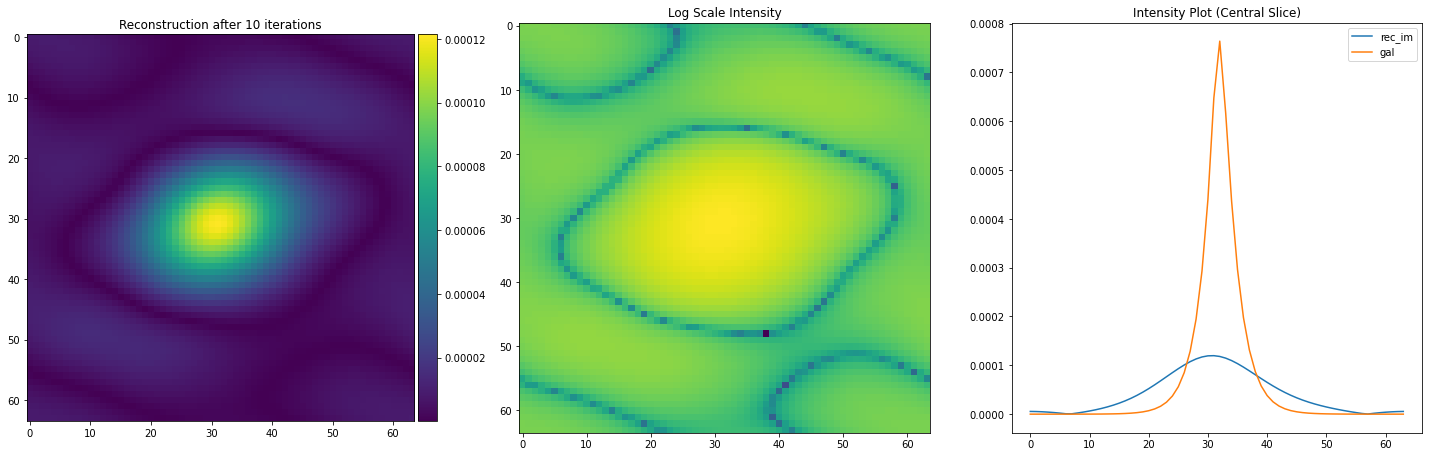

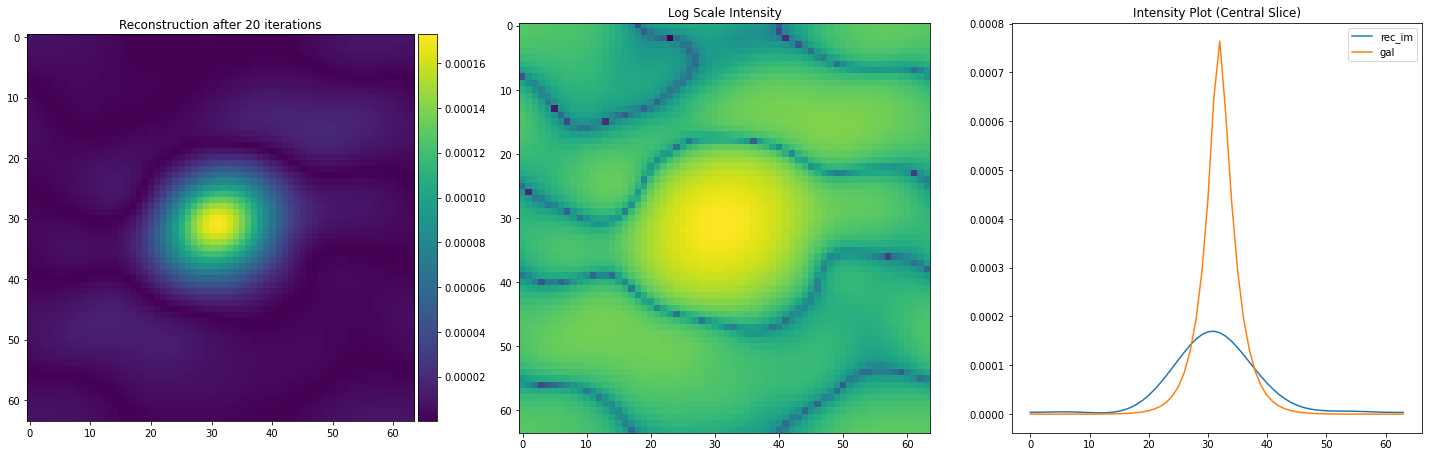

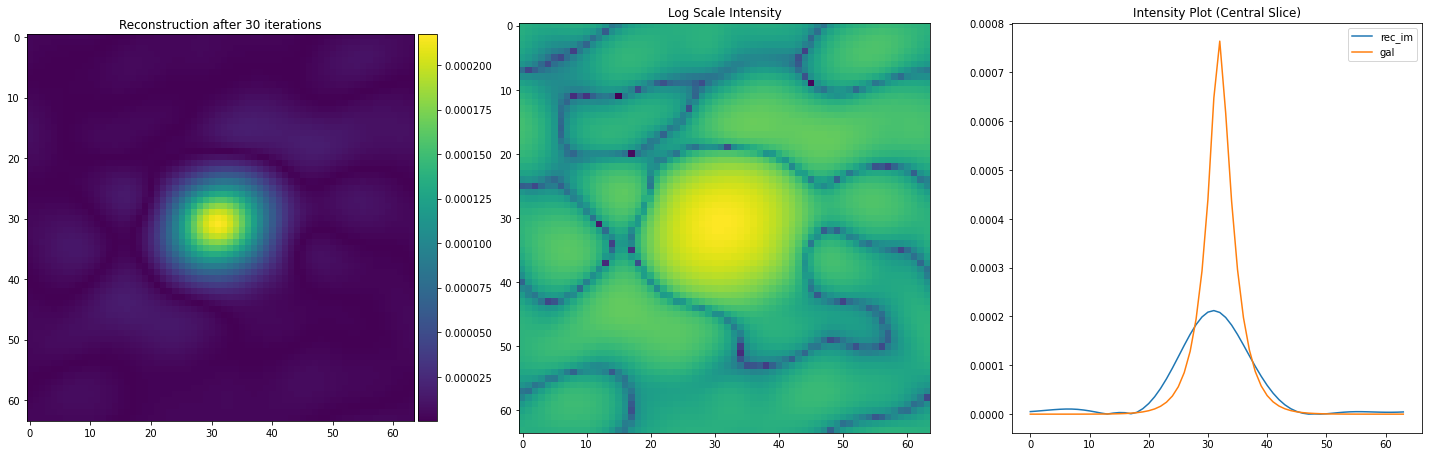

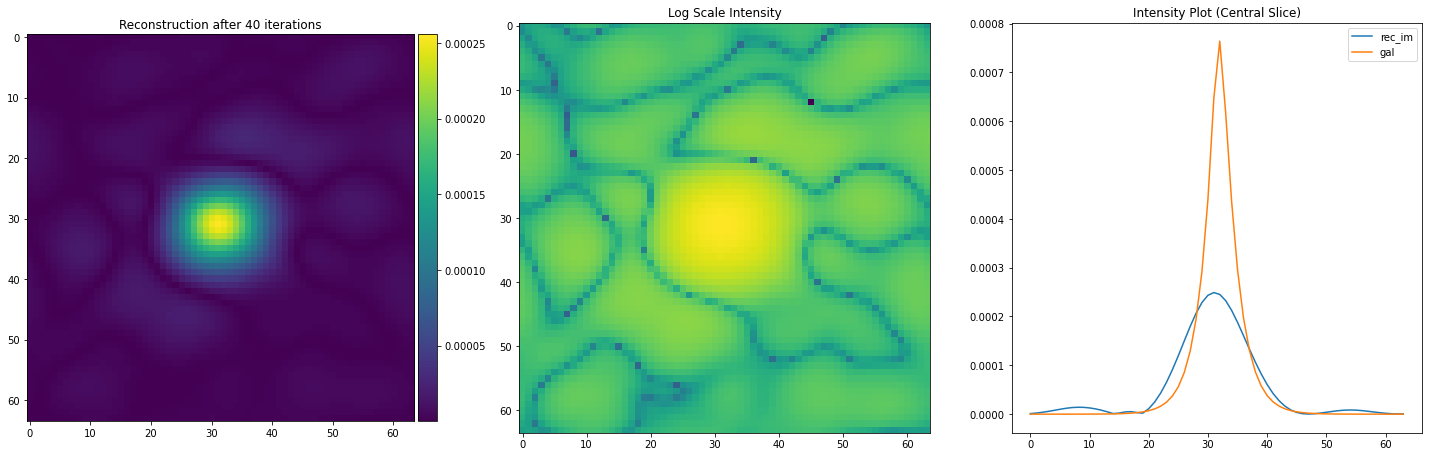

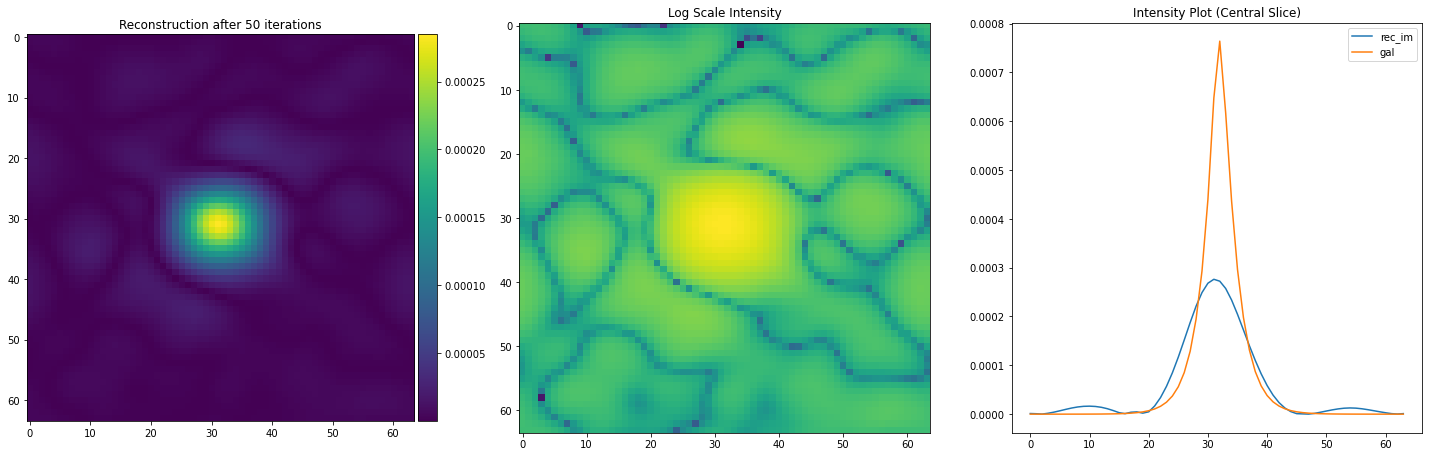

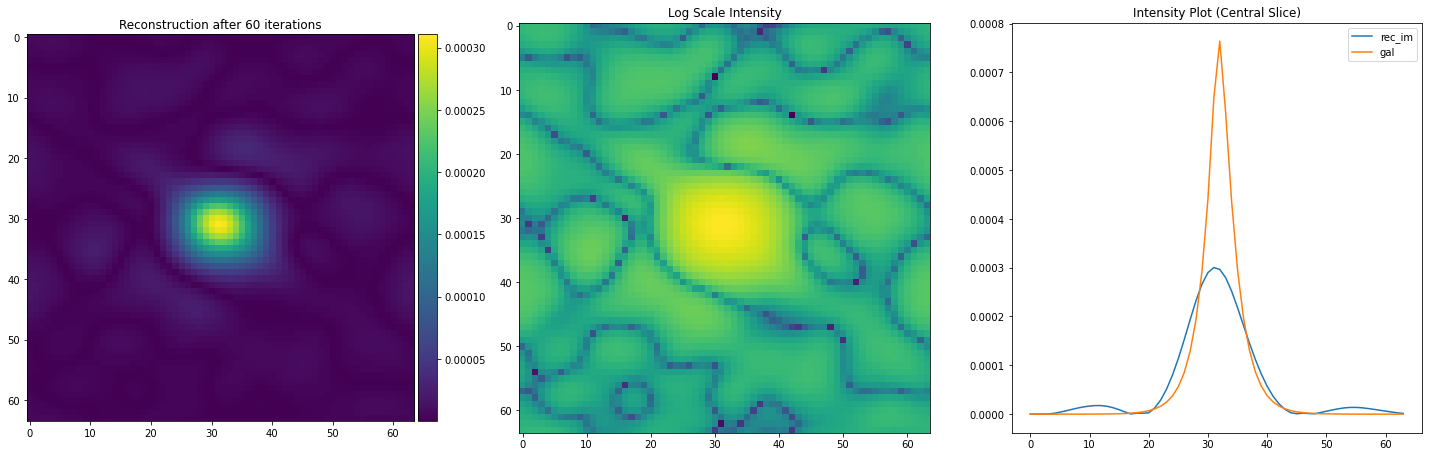

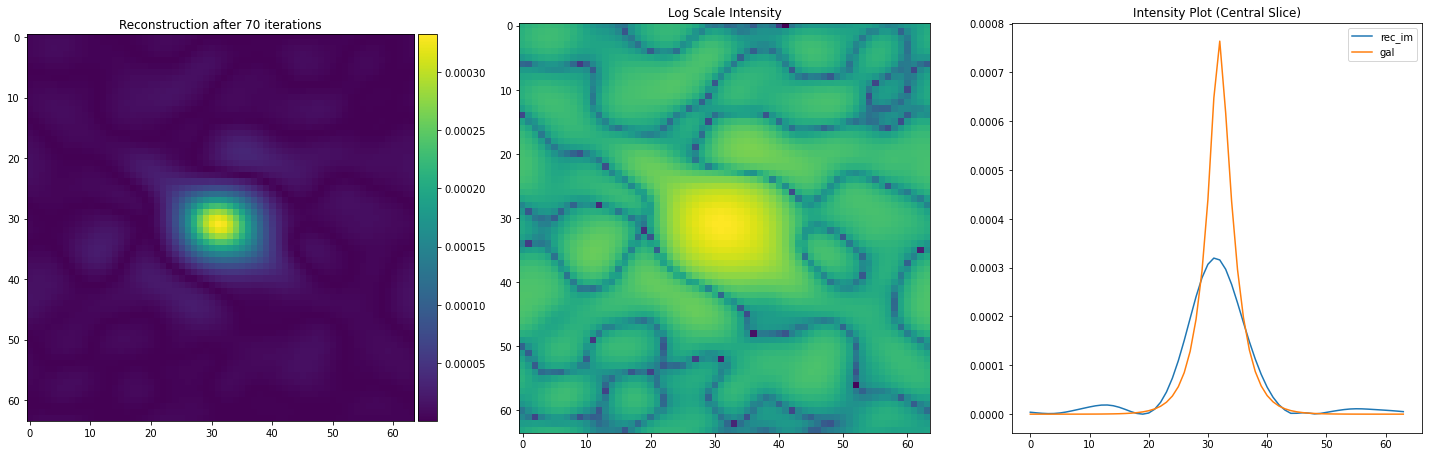

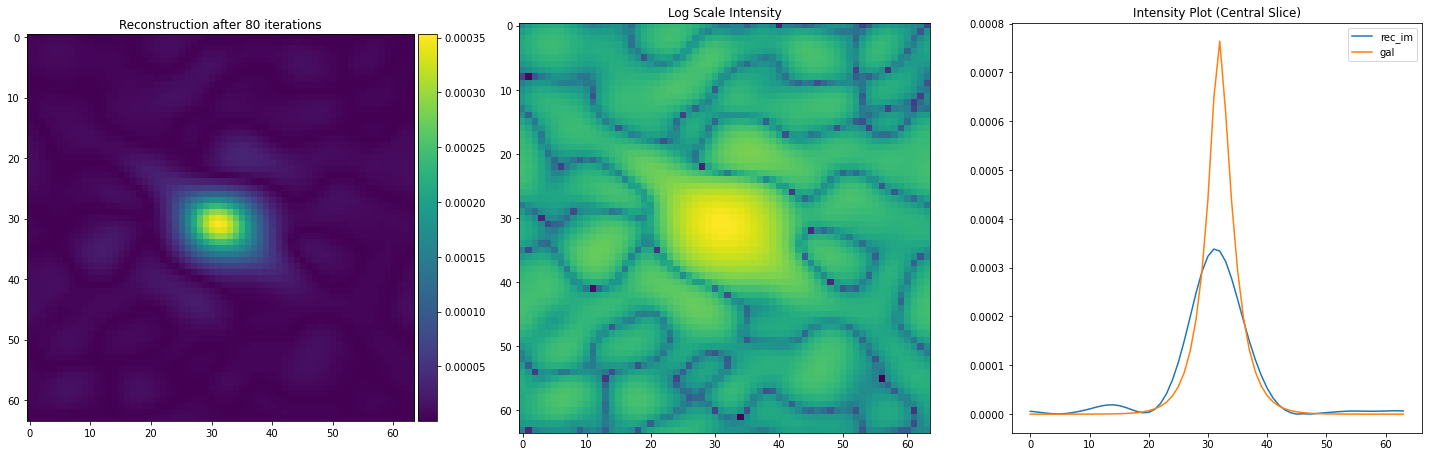

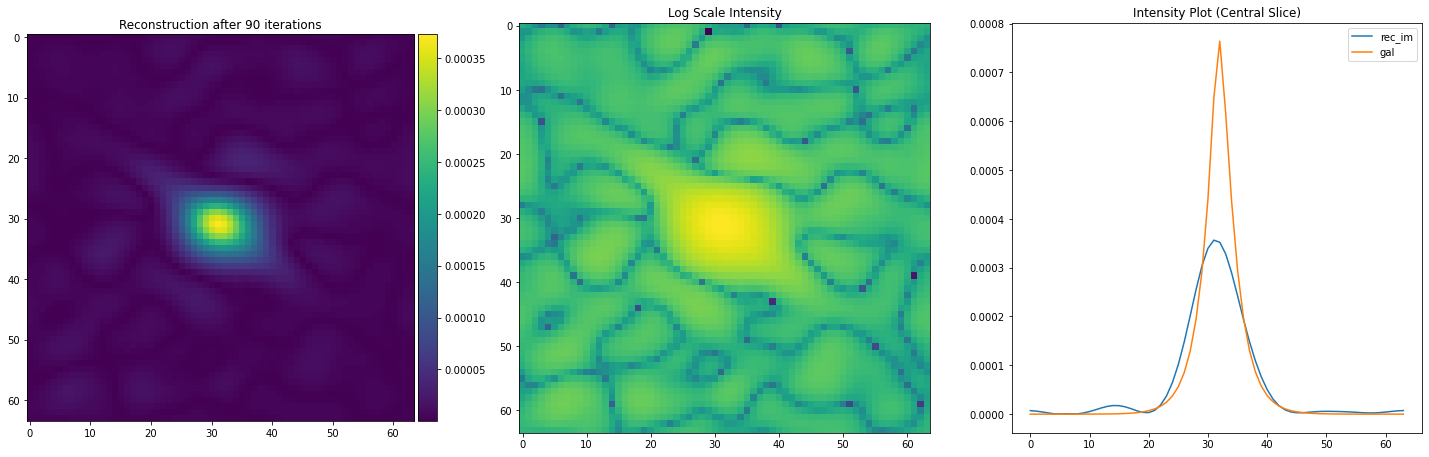

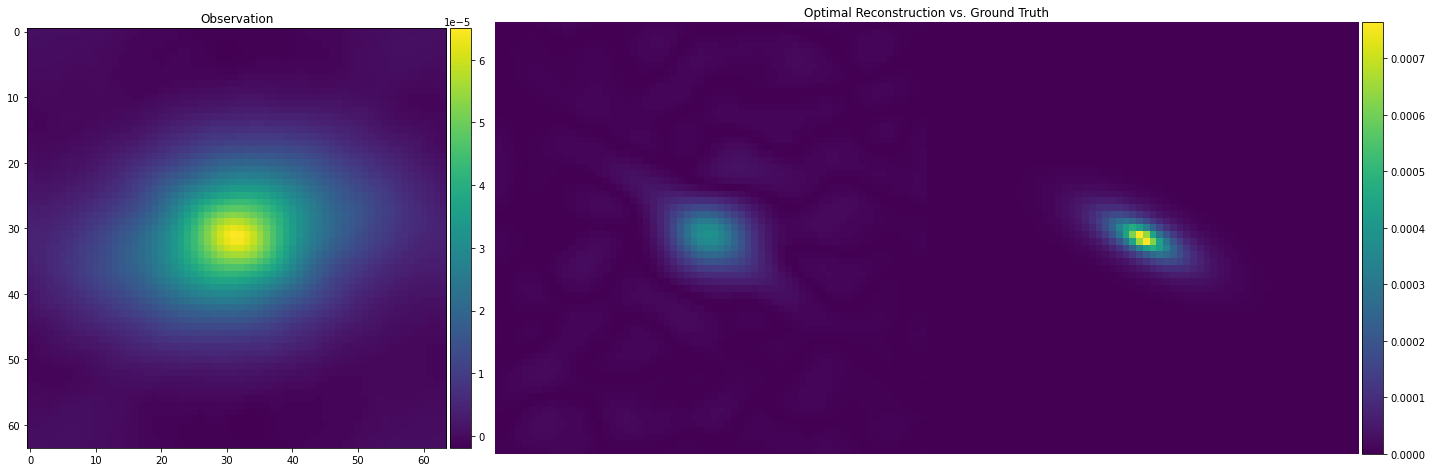

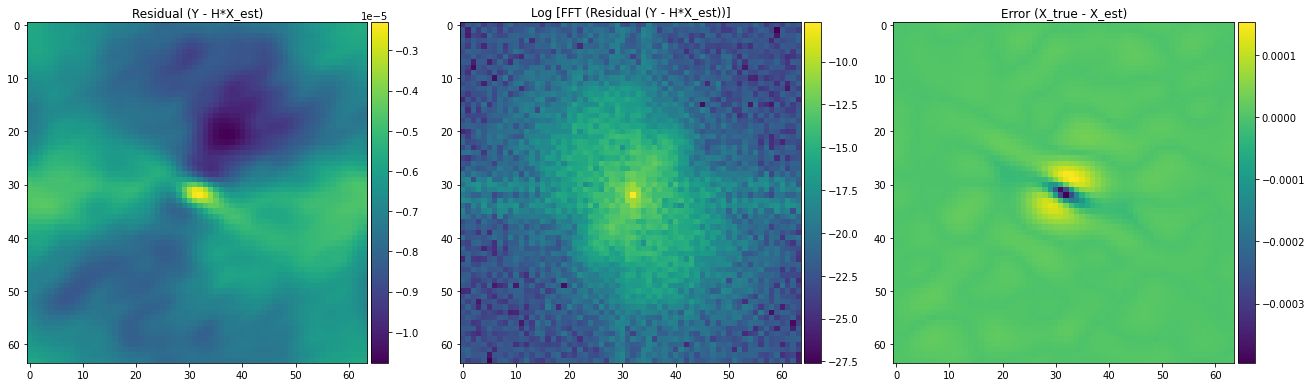

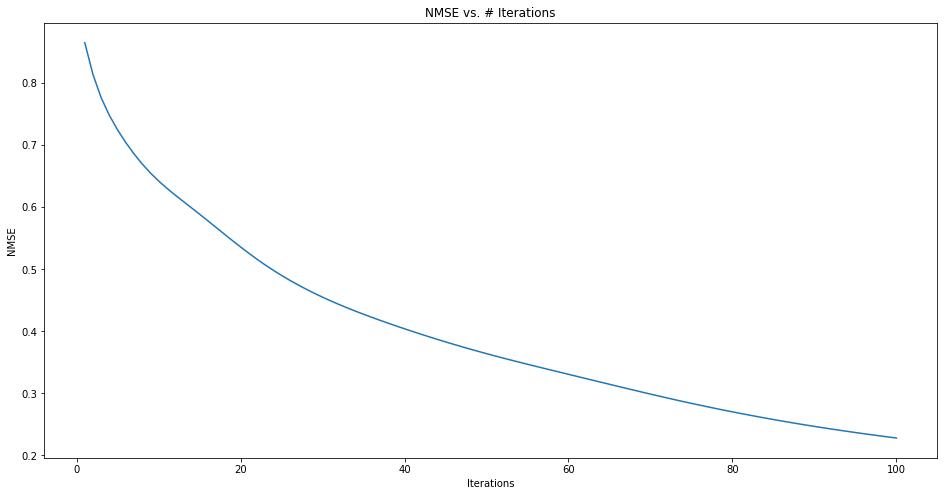


Minimum NMSE = 0.2279629985765752 (at 99 iterations)


In [14]:
rec_np, nmse_np = ADMM_np(gal, final_gal, psf, n_iter, disp_step)

### TensorFlow Results

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


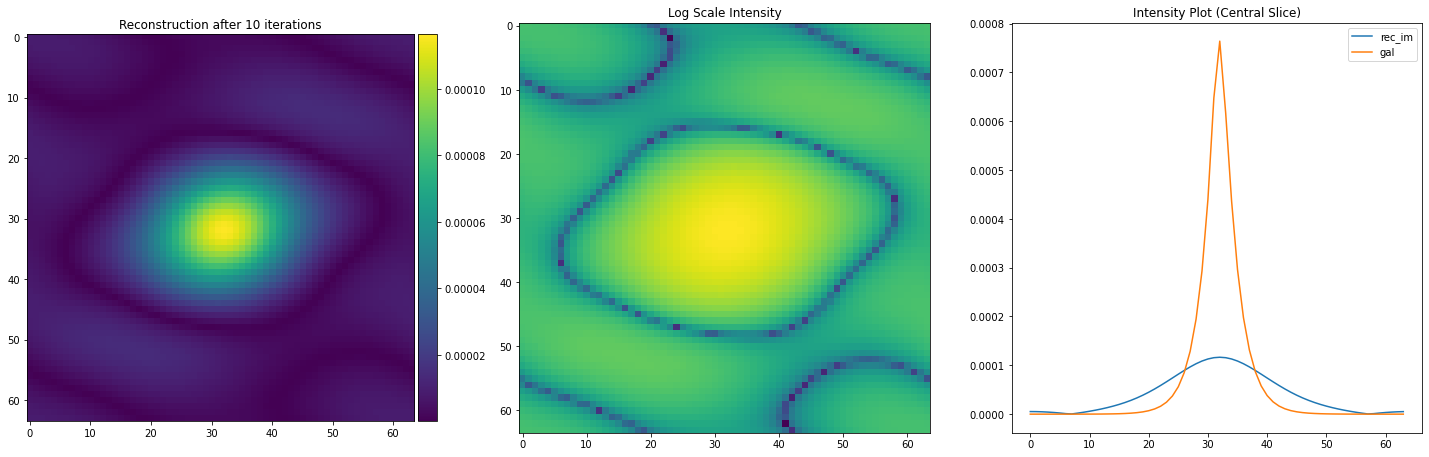

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


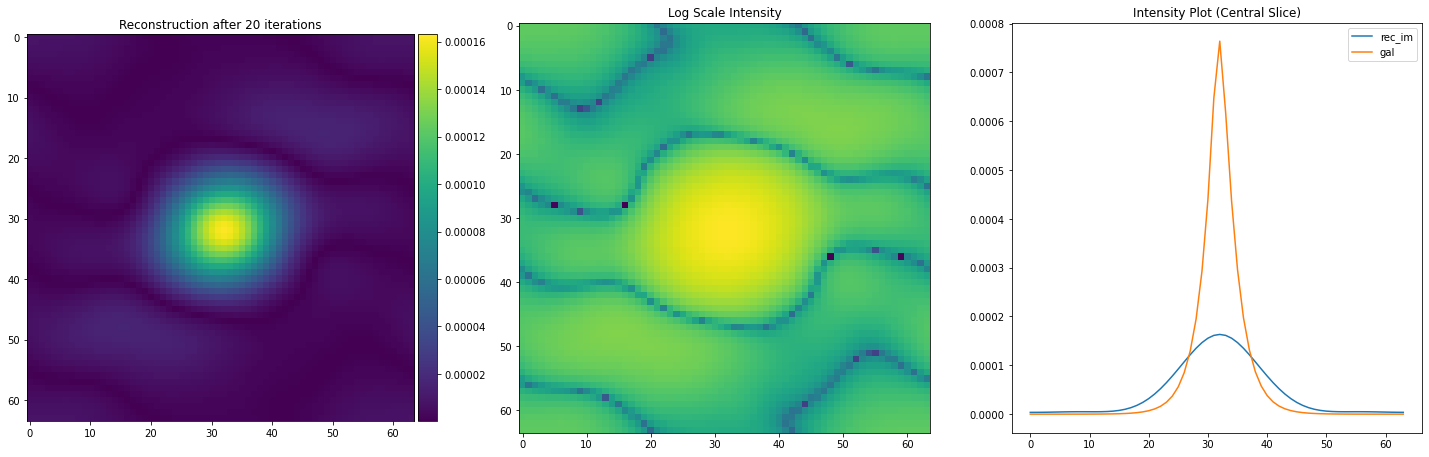

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


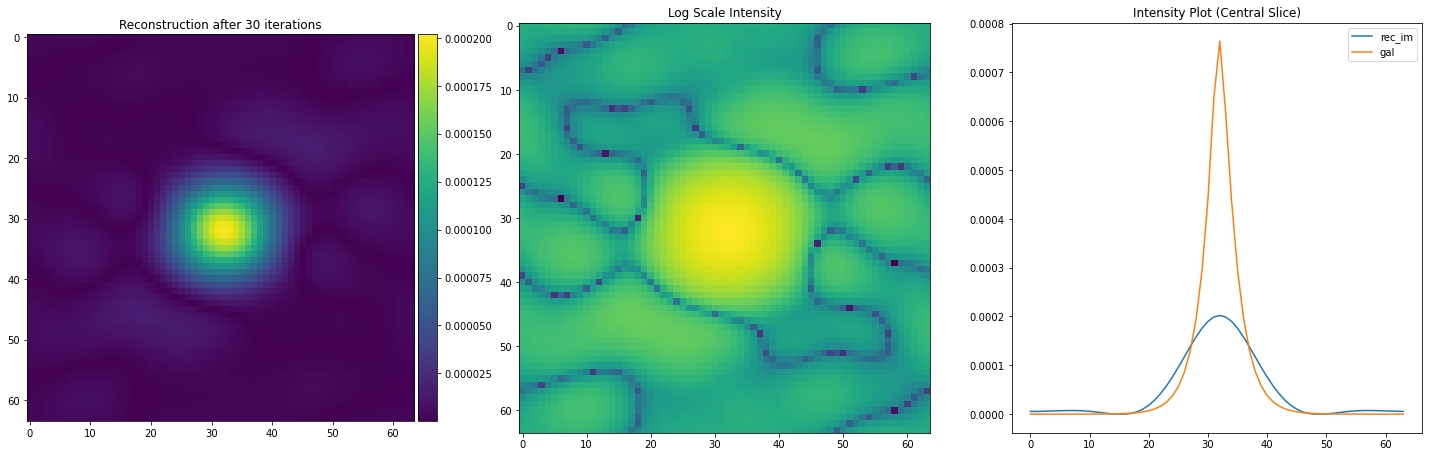

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


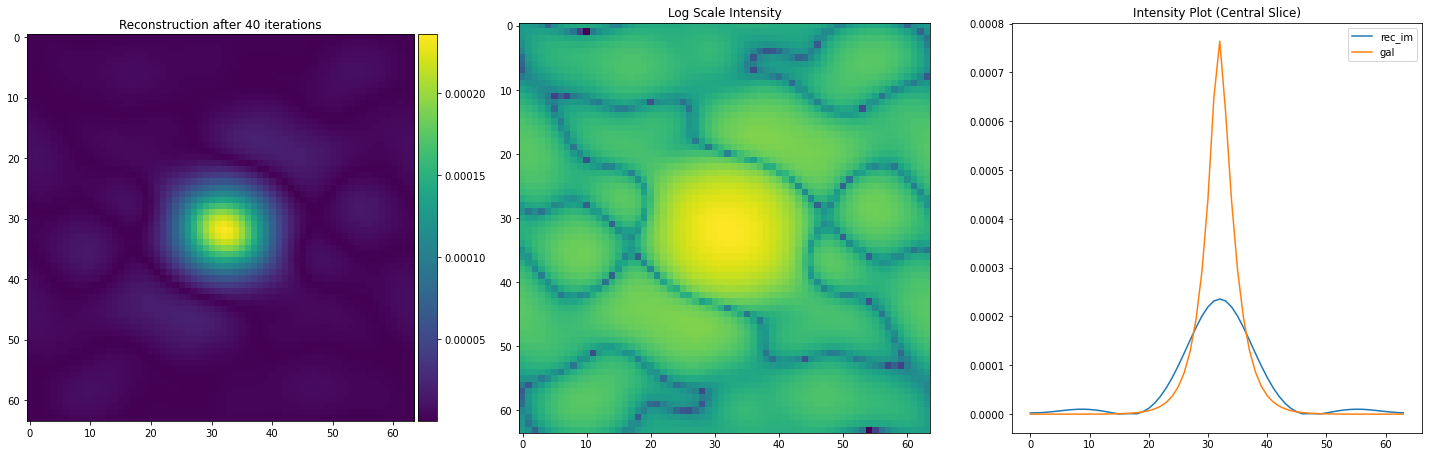

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


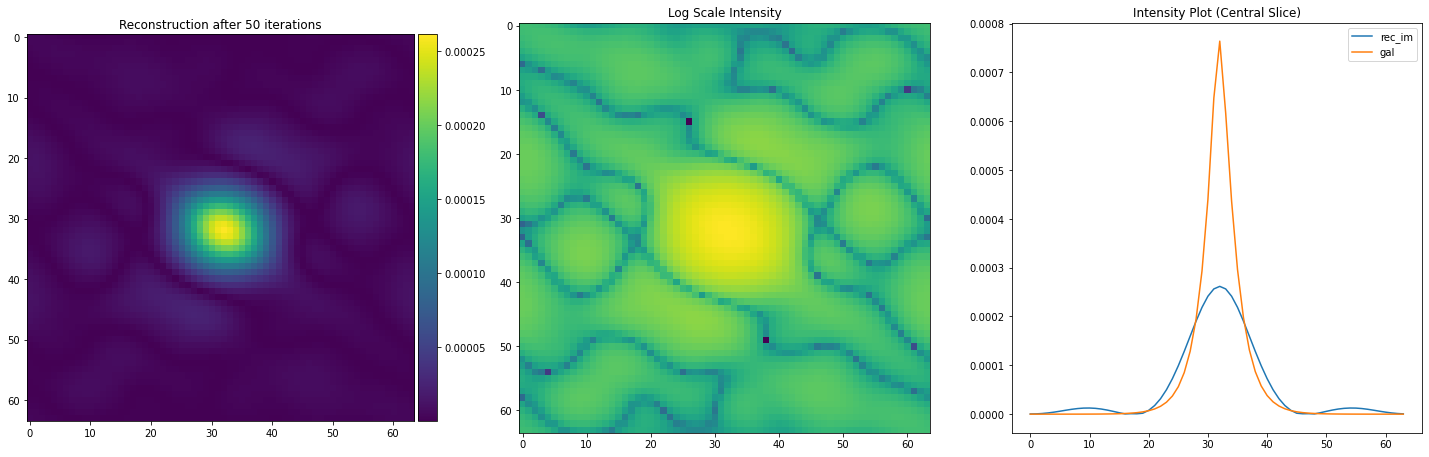

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


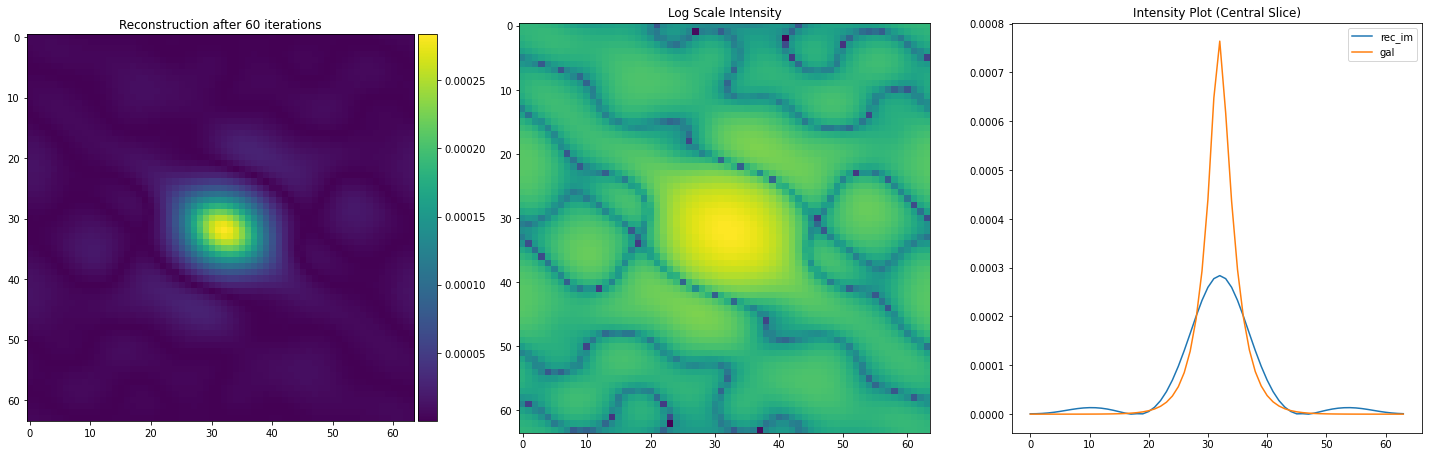

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


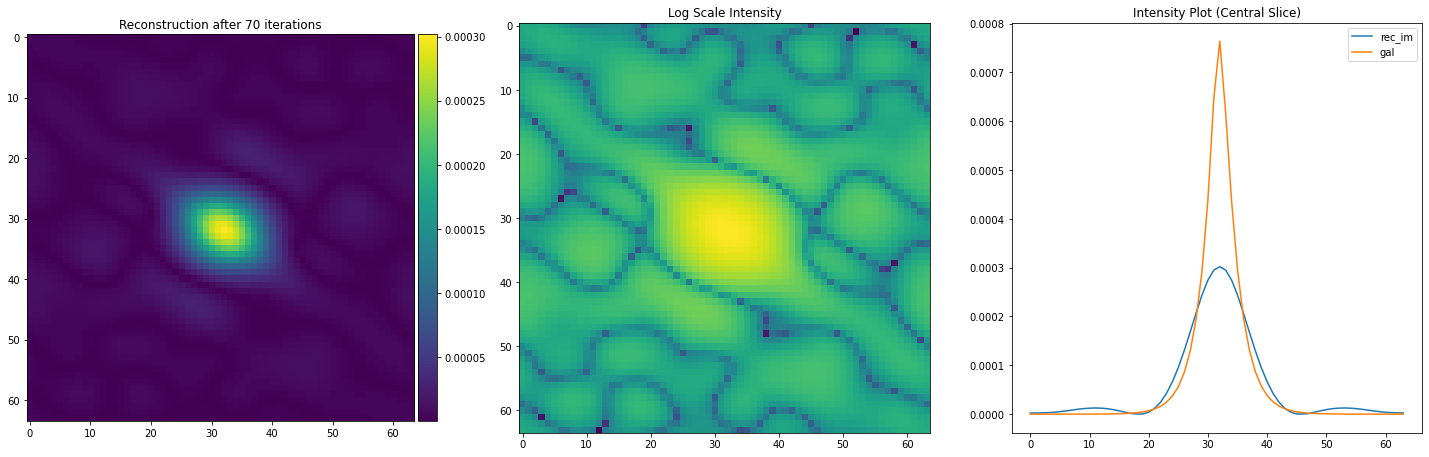

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


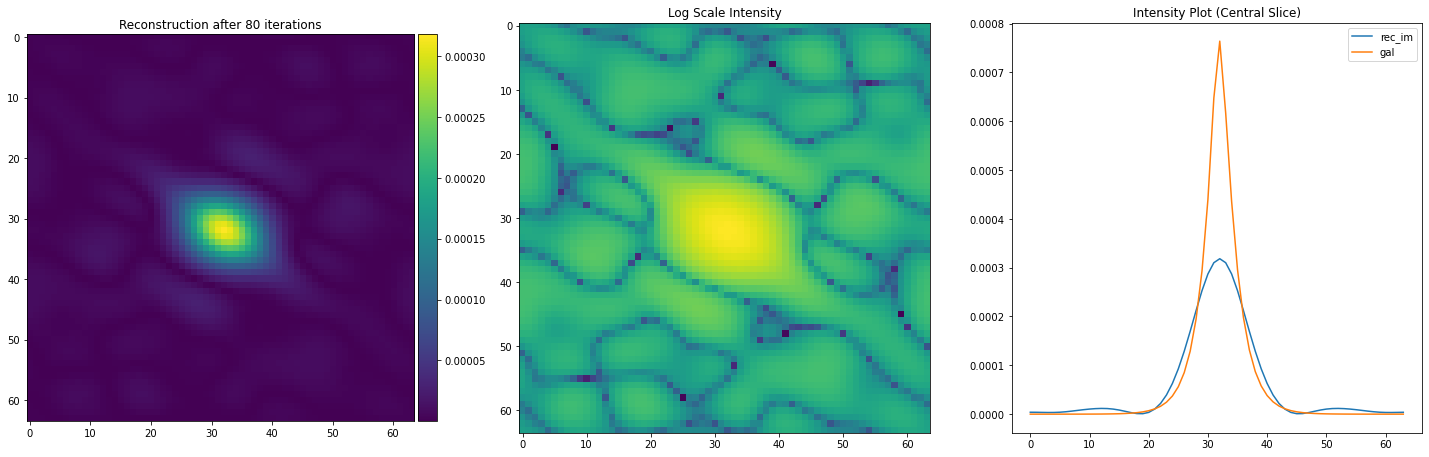

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


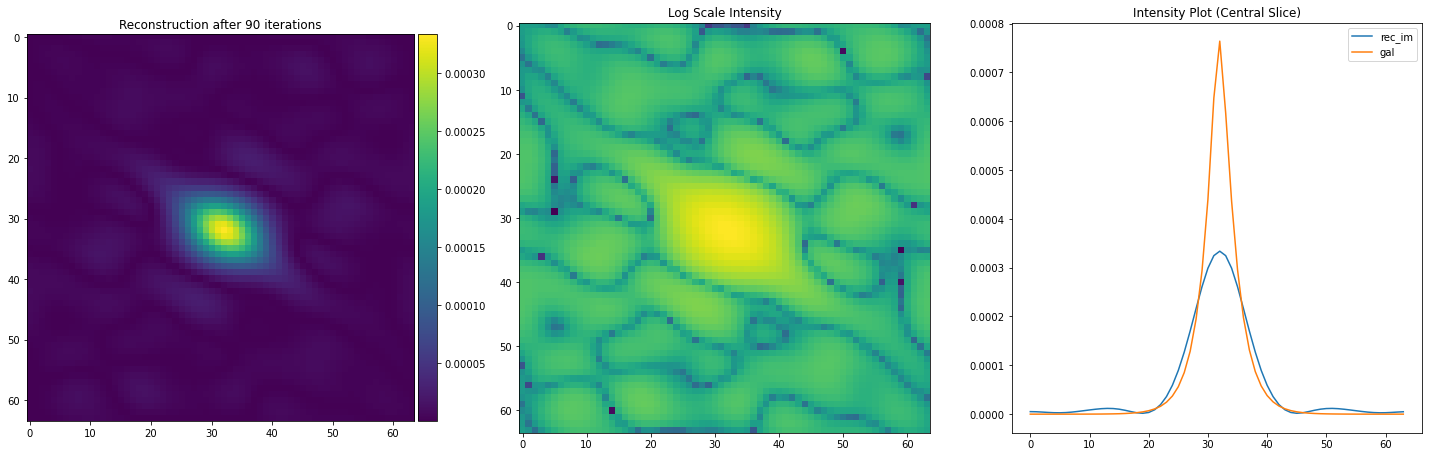

/Users/ua264756/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:171: ComplexWarning: Casting complex values to real discards the imaginary part


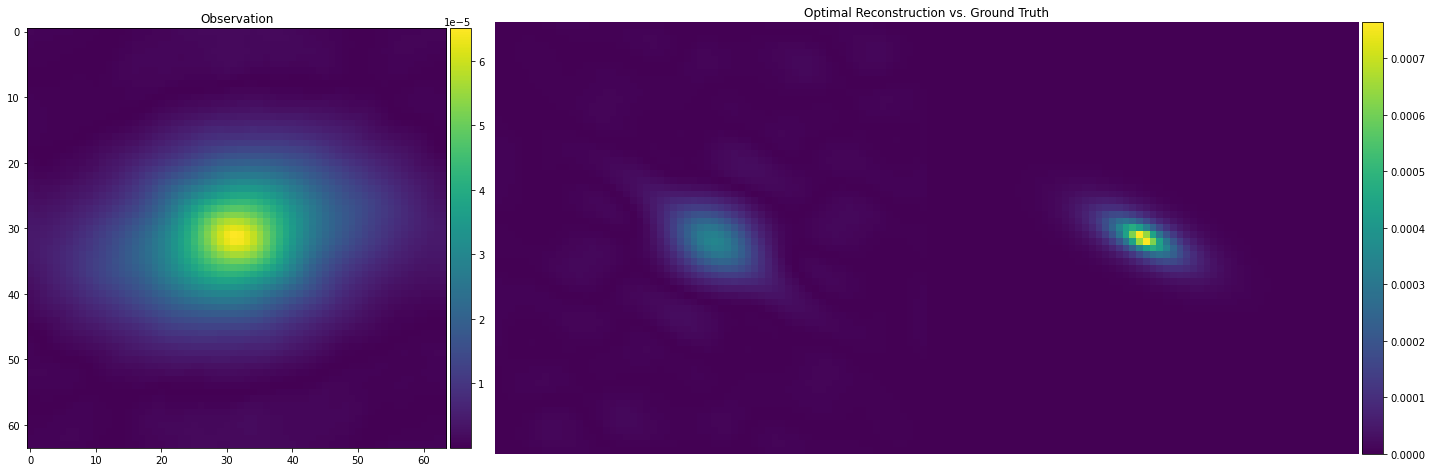

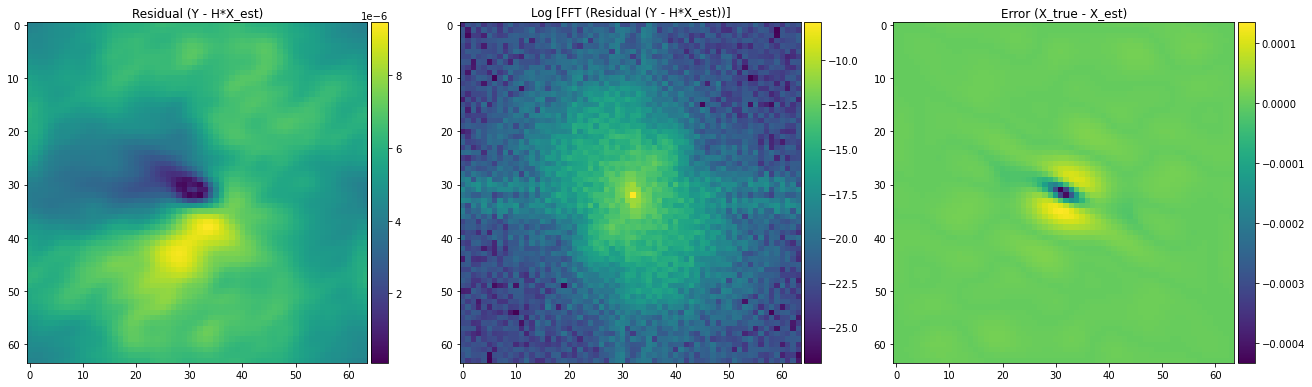

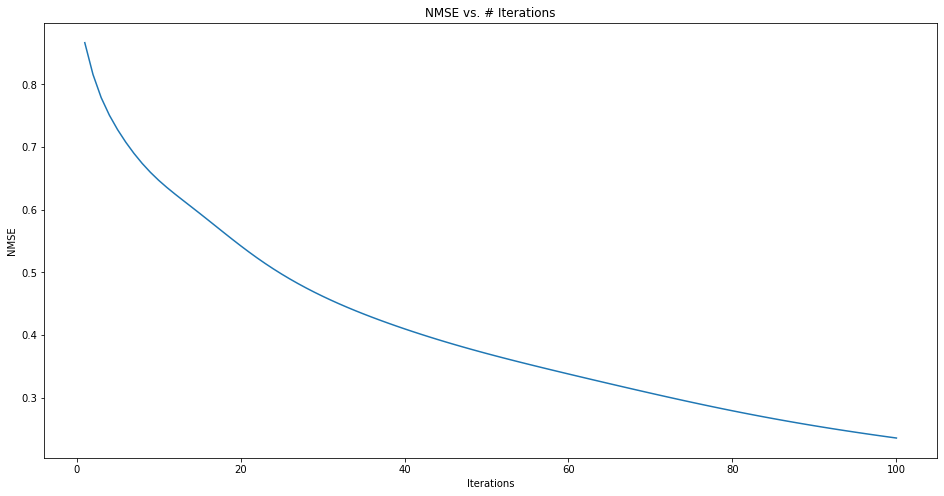


Minimum NMSE = 0.23594454855241692 (at 99 iterations)


In [15]:
rec_tf, nmse_tf = ADMM_tf(gal, final_gal, psf, n_iter, disp_step)

### Comparison - TF and NP

In [16]:
rec_im_diff = tf.keras.backend.get_value(rec_tf) - rec_np
nmse_diff = nmse_tf - nmse_np

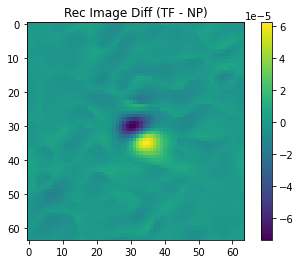

In [17]:
plt.imshow(rec_im_diff)
plt.colorbar()
plt.title('Rec Image Diff (TF - NP)')
plt.show()

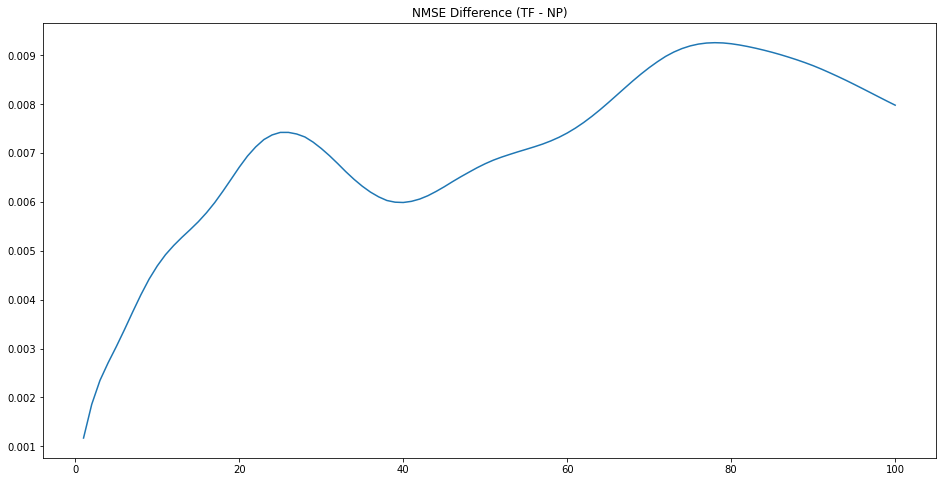

In [18]:
plt.figure(figsize=(16,8))
plt.plot(range(1,n_iter+1), nmse_diff)
plt.title('NMSE Difference (TF - NP)')
plt.show()